In [1]:
import h5py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gc

In [4]:
import pandas as pd
import seaborn as sns

In [5]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from glob import glob

In [8]:
from tqdm.auto import tqdm
import shelve

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneOut as LOSO
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [10]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split as tts

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [12]:
all_files = [h5py.File(x) for x in glob("*/*.hdf5")]

In [13]:
new_annot_filename = "HD_EPIC_Sounds_annot.csv"
new_annot_df = pd.read_csv(new_annot_filename)

In [14]:
new_annot_df = new_annot_df.sort_values(["participant_id", "video_id", "start_sample"])

#### sampling rate: 48kHz

In [15]:
import matplotlib

In [16]:
import scipy as sp

def windowed_fft(wav_form, labels_csv, window_size=48000, non_overlap=24000, plot=True):
    #stft_obj = sp.signal.ShortTimeFFT() TODO: use this more moder api?
    f, t, stft = sp.signal.stft(x=wav_form, fs=48000, nperseg=window_size, noverlap=non_overlap)
    
    if plot:
        try:
            plt.pcolormesh(t, f, np.abs(stft), shading='gouraud', norm=matplotlib.colors.LogNorm())
            plt.title('STFT Magnitude')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.show()
        except:
            print("could not plot")

    stft = np.abs(stft.transpose((1, 0)))
    labels = np.zeros(len(stft))
    if labels_csv is not None:
        for _, line in labels_csv.iterrows():
            start = (line.start_sample - window_size + non_overlap) // non_overlap
            stop = (line.stop_sample - window_size + non_overlap) // non_overlap
            #print(start, stop)
            labels[start:stop] = 1
    return f,t, stft, labels

In [17]:
import librosa

In [18]:
def spectral_cover(y, sr=48000, gamma=1.5):
    """
    Computes the Spectral Cover (SP) feature, which boosts high-frequency components 
    and makes the feature sensitive to absolute signal level.
    
    Parameters:
        - y: Raw audio signal (NumPy array)
        - sr: Sampling rate (default: 48 kHz)
        - gamma: Sensitivity parameter (1 ≤ gamma ≤ 2)

    Returns:
        - Spectral Cover value (scalar)
    """
    # Compute magnitude spectrum (STFT)
    stft = np.abs(librosa.stft(y, n_fft=2048))  # Ensure n_fft matches librosa default
    freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)  # Match n_fft to STFT

    amplitude_spectrum = np.mean(stft, axis=1)  # Averaging across time

    if amplitude_spectrum.shape[0] != freqs.shape[0]:  # Ensure same shape
        freqs = np.linspace(0, sr / 2, amplitude_spectrum.shape[0])

    numerator = np.sum((amplitude_spectrum * freqs) ** 2)
    denominator = np.sum(amplitude_spectrum) ** gamma
    return numerator / denominator if denominator > 0 else 0

In [19]:
def extract_audio_features_sliding_window(audio_data, sr=48000, window_size=2, hop_size=2, n_mfcc=13, labels_df=None):
    """
    Extracts audio features using a sliding window approach.
    
    Parameters:
        - audio_data: NumPy array containing the raw audio signal
        - sr: Sampling rate (default: 48 kHz)
        - window_size: Window length in seconds
        - hop_size: Hop length in seconds (overlap control)
        - n_mfcc: Number of MFCC coefficients to extract
    
    Returns:
        - feature_matrix: (num_windows, feature_dim) numpy array
    """
    # Convert seconds to samples
    win_length = int(window_size * sr)
    hop_length = int(hop_size * sr)

    # Compute number of windows
    num_windows = (len(audio_data) - win_length) // hop_length + 1
    feature_matrix = []

    for i in range(num_windows):
        start = i * hop_length
        end = start + win_length
        y_win = audio_data[start:end]

        # Compute features for the window
        mfccs = librosa.feature.mfcc(y=y_win, sr=sr, n_mfcc=n_mfcc)
        spectral_centroid = librosa.feature.spectral_centroid(y=y_win, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_win, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y_win, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y_win, sr=sr)
        spectral_cover_res = spectral_cover(y=y_win, sr=sr, gamma=1.5)
        chroma = librosa.feature.chroma_stft(y=y_win, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y_win)
        rms_energy = librosa.feature.rms(y=y_win)

        # Aggregation function (Mean, Std, Min, Max, Median)
        def aggregate_feature(feature):
            return np.array([np.mean(feature), np.std(feature), np.min(feature), np.max(feature), np.median(feature)])

        # Flatten and collect features
        feature_vector = np.hstack([
            aggregate_feature(mfccs),
            aggregate_feature(spectral_centroid),
            aggregate_feature(spectral_bandwidth),
            aggregate_feature(spectral_contrast),
            aggregate_feature(spectral_rolloff),            
            aggregate_feature(chroma),
            aggregate_feature(zero_crossing_rate),
            aggregate_feature(rms_energy),
            spectral_cover_res
        ])
        feature_matrix.append(feature_vector)
        
    labels = np.zeros(len(feature_matrix))
        
    if labels_df is not None:
        for _, line in labels_df.iterrows():
            if (line.stop_sample - line.start_sample) / sr < 2:
                continue
            start = (line.start_sample - win_length + hop_length) // hop_length
            stop = (line.stop_sample - win_length + hop_length) // hop_length
            labels[start:stop] = 1

    return np.array(feature_matrix), labels

In [19]:
features = ["mfccs", "sp_centroid", "sp_bandwidth", "sp_contrast", "sp_rolloff", "chroma", "ZCR", "rms_energy"]
feat_agg = np.concatenate([[f"{feat}_mean", f"{feat}_std", f"{feat}_min", f"{feat}_max", f"{feat}_median"] for feat in features] + [["sp_cover"]])

In [ ]:
feat_agg.shape

In [20]:
def extract_log_mel_spectrogram_sliding_window(audio_data, sr=48000, window_size=2, hop_size=2, n_mels=128, n_fft=2048, hop_length=None, labels_df=None):
    """
    Computes log-Mel spectrogram features using a sliding window approach.
    
    Parameters:
        - audio_data: 1D numpy array of raw audio
        - sr: Sampling rate
        - window_size: Duration of each window in seconds
        - hop_size: Hop size between windows in seconds
        - n_mels: Number of Mel bands
        - n_fft: FFT window size
        - hop_length: STFT hop length (in samples); defaults to 1/4 of n_fft
    
    Returns:
        - A 3D numpy array of shape (num_windows, n_mels, num_frames_per_window)
    """
    win_length = int(window_size * sr)
    hop_samples = int(hop_size * sr)
    hop_length = hop_length or n_fft // 4
    num_windows = (len(audio_data) - win_length) // hop_samples + 1

    segments = []

    for i in range(num_windows):
        start = i * hop_samples
        end = start + win_length
        y_win = audio_data[start:end]

        # Compute Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y_win,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            power=2.0  # Power spectrogram (amplitude squared)
        )

        # Convert to log scale (dB)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        segments.append(log_mel_spec)

            
    labels = np.zeros(len(segments))
        
    if labels_df is not None:
        for _, line in labels_df.iterrows():
            if (line.stop_sample - line.start_sample) / sr < 2:
                continue
            start = (line.start_sample - win_length + hop_samples) // hop_samples
            stop = (line.stop_sample - win_length + hop_samples) // hop_samples
            labels[start:stop] = 1

    return np.array(segments), labels # Shape: (num_windows, n_mels, frames_per_window)

In [21]:
f = all_files[0]
key = list(f.keys())[0]
tap_water_df = new_annot_df[(new_annot_df.video_id == key) & (new_annot_df["class"]=="tap water")]

In [21]:
Xs, ys = extract_log_mel_spectrogram_sliding_window(np.array(f[key]), labels_df=tap_water_df)

In [21]:
def extract_raw_data_sliding_window(audio_data, sr=48000, window_size=2, hop_size=2, labels_df=None):
    # Convert seconds to samples
    win_length = int(window_size * sr)
    hop_length = int(hop_size * sr)

    # Compute number of windows
    num_windows = (len(audio_data) - win_length) // hop_length + 1
    feature_matrix = []
    
    for i in range(num_windows):
        start = i * hop_length
        end = start + win_length
        y_win = audio_data[start:end]
        if len(y_win) == win_length:
            feature_matrix.append(y_win)
        
    labels = np.zeros(len(feature_matrix))
        
    if labels_df is not None:
        for _, line in labels_df.iterrows():
            start = (line.start_sample - win_length + hop_length) // hop_length
            stop = (line.stop_sample - win_length + hop_length) // hop_length
            labels[start:stop] = 1

    return np.array(feature_matrix), labels

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [23]:
class LogMelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (16, 64, 94)
        x = self.pool(F.relu(self.conv2(x)))  # -> (32, 32, 47)
        x = self.pool(F.relu(self.conv3(x)))  # -> (64, 16, 23)
        x = self.pool(F.relu(self.conv4(x)))  # -> (128, 8, 11)
        x = self.pool(F.relu(self.conv5(x)))  # -> (256, 4, 5)
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
def load_all_recs_from_file(f, features="classic", reset=False, target="water"):
    save_str = str(f) + ("_" + features if features != "classic" else "") + "_" + target
    if not reset:
        with shelve.open("saved_features") as shf:
            
            Xs, ys = shf.get(save_str, (None, None))
        
        if Xs is not None and not reset:
            return Xs, ys

    print("calculating, load_all_recs_from_file, target:", target)
    Xs = []
    ys = []
    for key in tqdm(f.keys()):
        water_df = new_annot_df[(new_annot_df.video_id == key) & (new_annot_df["class"]==target)]
        if features == "classic":
            X, y = extract_audio_features_sliding_window(np.array(f[key]), labels_df=water_df)
        elif features == "raw":
            X, y = extract_raw_data_sliding_window(np.array(f[key]), labels_df=water_df)
        elif features == "logmel":
            X, y = extract_log_mel_spectrogram_sliding_window(np.array(f[key]), labels_df=water_df)
        Xs.append(X)
        ys.append(y)
    Xs = np.concatenate(Xs)
    ys = np.concatenate(ys)
    with shelve.open("saved_features") as shf:
        shf[save_str] = (Xs, ys)
    return Xs, ys

In [26]:
def load_files(files, concat=True, features="classic", reset=False, target="water"):
    X_all, y_all = [], []
    for file in tqdm(files):
        Xs, ys = load_all_recs_from_file(file, features=features, reset=reset, target=target)
        X_all.append(Xs)
        y_all.append(ys)
    if concat:
        return np.concatenate(X_all), np.concatenate(y_all)
    else:
        return X_all, y_all

### Ratio of Water Annotation out of all annotations:

(around 10%)

In [28]:
X_all.shape

(74285, 41)

In [27]:
X_all, y_all = load_files(all_files, target="water", reset=False)

  0%|          | 0/9 [00:00<?, ?it/s]

In [32]:
X_all_tap, y_all_tap = load_files(all_files, target="tap water", reset=False)

  0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
X_all_lo, y_all_lo = load_files(all_files, False, reset=False)
X_all_tap_lo, y_all_tap_lo = load_files(all_files, False, reset=False, target="tap water")

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [35]:
#X, y = extract_audio_features_sliding_window(np.array(f[keys[0]]), labels_df=water_df)

In [45]:
try:
    with shelve.open("ml_res") as shf:
        res_df = shf["res_df"]
except:
    results = []
    for k in tqdm(range(10)):
        for X, y, target in [(X_all, y_all, "water"), (X_all_tap, y_all_tap, "tap water")]:
            clf = RFC(n_estimators=200, class_weight="balanced")
            X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3)
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            f1 = f1_score(y_test, preds)
            acc = accuracy_score(y_test, preds)
            prec = precision_score(y_test, preds)
            rec = recall_score(y_test, preds)
            results.append({"test_part": "all", "target": target, "f1" : f1, "acc" : acc, "precision" : prec, "recall" : rec})
    
    res_df = pd.DataFrame(results)
    with shelve.open("ml_res") as shf:
        shf["res_df"] = res_df

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
res_df["classifier"] = "Random Forest"

In [47]:
res_df

,test_part,target,f1,acc,precision,recall,classifier
0,all,water,0.671747,0.947815,0.918210,0.529595,Random Forest
1,all,tap water,0.757946,0.973346,0.934673,0.637423,Random Forest
2,all,water,0.688804,0.949116,0.918741,0.550922,Random Forest
3,all,tap water,0.739566,0.972000,0.913402,0.621318,Random Forest
4,all,water,0.684985,0.949071,0.923653,0.544332,Random Forest
5,all,tap water,0.732993,0.971821,0.917021,0.610482,Random Forest
6,all,water,0.672702,0.948084,0.918856,0.530567,Random Forest
7,all,tap water,0.741554,0.972539,0.927138,0.617875,Random Forest
8,all,water,0.671613,0.946379,0.927162,0.526497,Random Forest
9,all,tap water,0.756148,0.973750,0.929303,0.637386,Random Forest


In [48]:
res_df.groupby("target").mean()

C:\Users\Robin\AppData\Local\Temp\ipykernel_13204\372413503.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_df.groupby("target").mean()


,f1,acc,precision,recall
target,,,,
tap water,0.740865,0.972467,0.922173,0.619186
water,0.672660,0.946585,0.920369,0.530091


In [49]:
len(Xs_lo)

9

In [50]:
try:
    with shelve.open("ml_res") as shf:
        res_df_lo = shf["res_df_lo"]
except:
    results_lo = []
    for k in range(10):
        for Xs_lo, ys_lo, target in [(X_all_lo, y_all_lo, "water"), (X_all_tap_lo, y_all_tap_lo, "tap water")]:
            cv = LOSO()
            for train_ind, test_ind in tqdm(cv.split(Xs_lo), total=9):
                X_train = np.concatenate(np.array(Xs_lo, dtype=object)[train_ind])
                y_train = np.concatenate(np.array(ys_lo, dtype=object)[train_ind])
                
                X_test = np.concatenate(np.array(Xs_lo, dtype=object)[test_ind])
                y_test = np.concatenate(np.array(ys_lo, dtype=object)[test_ind])
                clf = RFC(n_estimators=200, class_weight="balanced")
                clf.fit(X_train, y_train)
                preds = clf.predict(X_test)
                print("testing rf on", test_ind, f1_score(y_test, preds))
                f1 = f1_score(y_test, preds)
                acc = accuracy_score(y_test, preds)
                prec = precision_score(y_test, preds)
                rec = recall_score(y_test, preds)
                results_lo.append({"test_part": str(test_ind[0]), "target": target, "f1" : f1, "acc" : acc, "precision" : prec, "recall" : rec})
    
    res_df_lo = pd.DataFrame(results_lo)
    with shelve.open("ml_res") as shf:
        shf["res_df_lo"] = res_df_lo

In [51]:
res_df_lo.groupby("target").mean()

C:\Users\Robin\AppData\Local\Temp\ipykernel_13204\421084079.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_df_lo.groupby("target").mean()


,f1,acc,precision,recall
target,,,,
tap water,0.467570,0.95400,0.756137,0.352211
water,0.448217,0.92428,0.776414,0.336449


In [52]:
from sklearn.dummy import DummyClassifier as DCF

In [53]:
## calculate chance level:
def chance_level(y_train,y_test):
    dummy_res = []
    # find the best performing dummy classifier
    for strategy in ["most_frequent", "prior", "stratified", "uniform"]:
        dcf = DCF(strategy=strategy)
        dcf.fit(y_train, y_train)
        preds = dcf.predict(y_test)
        f1 = f1_score(y_test, preds)
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        dummy_res.append({"strategy": strategy, "f1" : f1, "acc" : acc, "precision" : prec, "recall" : rec})
    return pd.DataFrame(dummy_res)

In [54]:
dfs = []
for Xs_lo, ys_lo, target in [(X_all_lo, y_all_lo, "water"), (X_all_tap_lo, y_all_tap_lo, "tap water")]:
    cv = LOSO()
    for train_ind, test_ind in tqdm(cv.split(Xs_lo), total=9):
        X_train = np.concatenate(np.array(Xs_lo, dtype=object)[train_ind])
        y_train = np.concatenate(np.array(ys_lo, dtype=object)[train_ind])
        
        X_test = np.concatenate(np.array(Xs_lo, dtype=object)[test_ind])
        y_test = np.concatenate(np.array(ys_lo, dtype=object)[test_ind])

        chance_df = chance_level(y_train, y_test)
        chance_df["target"] = target
        chance_df["test_part"] = test_ind[0]
        dfs.append(chance_df)
all_chance_df = pd.concat(dfs)
        

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local

In [55]:
all_chance_df["classifier"] = "Baseline"

In [56]:
all_chance_df.test_part

0    0
1    0
2    0
3    0
0    1
    ..
3    7
0    8
1    8
2    8
3    8
Name: test_part, Length: 72, dtype: int32

In [57]:
res_df_lo.test_part = np.array(res_df_lo.test_part, dtype=int)

In [58]:
chnc_res = []
for X, y, target in [(X_all, y_all, "water"), (X_all_tap, y_all_tap, "tap water")]:
    X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3)
    chance_df = chance_level(y_train, y_test)
    chance_df["target"] = target
    chnc_res.append(chance_df)
chnc_df = pd.concat(chnc_res)

C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robin\AppData\Local

In [59]:
res_df_lo.groupby("target").mean()

,test_part,f1,acc,precision,recall
target,,,,,
tap water,4.0,0.467570,0.95400,0.756137,0.352211
water,4.0,0.448217,0.92428,0.776414,0.336449


In [60]:
del X_all_lo
del y_all_lo
del X_all_tap_lo
del y_all_tap_lo

import gc
gc.collect()

1284

In [61]:
y_test.mean()

0.06447994256483891

In [62]:
y_train.mean()

0.06430892901786572

### CNN Training:

In [63]:
def evaluate(model, val_loader, device, do_print=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    f1 = f1_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)

    if do_print:
        print(f"\nValidation Results:")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}\n")

    return acc, f1, precision, recall, all_preds, all_labels


In [40]:
X_all_mel, y_all_mel = load_files(all_files, target="water", reset=False, features="logmel")

  0%|          | 0/9 [00:00<?, ?it/s]

In [41]:
import gc
gc.collect()

452

In [42]:
es_steps = 25

In [43]:
X_train, X_test, y_train, y_test = tts(X_all_mel, y_all_mel, test_size=0.3)
del X_all_mel

device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

y_train_int = y_train.astype(np.int64)
class_counts = np.bincount(y_train_int)
class_weights = 1.0 / class_counts
class_weights = class_weights * (len(y_train) / class_weights.sum())  # optional normalization
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=0.15)

# Create dataset and dataloader
train_dataset = LogMelDataset(X_train, y_train)
val_dataset = LogMelDataset(X_val, y_val)
test_dataset = LogMelDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNNClassifier(num_classes=len(np.unique(y_all_mel))).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300

best_f1 = 0
best_model_state = None
steps = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / total

    ## early stopping and validation loss:
    acc, f1, precision, recall, _, _ = evaluate(model, val_loader, device, False)
    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict()  # reference to current weights
        # Clone the weights so they don’t get overwritten
        best_model_state = {k: v.clone() for k, v in best_model_state.items()}
        steps = 0
    elif steps >= es_steps:
        model.load_state_dict(best_model_state)
        print(f"stoping early and returning to best model with val F1 of {best_f1 * 100:.2f}")
        break
    else: 
        steps += 1

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}% | Val ACC: {acc*100:.2f}| Val F1: {f1*100:.2f} | Steps: {steps}")

Using device: cuda


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300 | Loss: 0.6481 | Accuracy: 68.22% | Val ACC: 77.96| Val F1: 36.12 | Steps: 0
Epoch 2/300 | Loss: 0.5671 | Accuracy: 76.95% | Val ACC: 88.62| Val F1: 42.64 | Steps: 0
Epoch 3/300 | Loss: 0.5597 | Accuracy: 78.13% | Val ACC: 74.17| Val F1: 35.19 | Steps: 1
Epoch 4/300 | Loss: 0.5402 | Accuracy: 79.23% | Val ACC: 79.08| Val F1: 38.23 | Steps: 2
Epoch 5/300 | Loss: 0.5278 | Accuracy: 79.92% | Val ACC: 75.09| Val F1: 36.81 | Steps: 3
Epoch 6/300 | Loss: 0.5134 | Accuracy: 80.21% | Val ACC: 83.03| Val F1: 42.83 | Steps: 0
Epoch 7/300 | Loss: 0.5050 | Accuracy: 80.10% | Val ACC: 85.13| Val F1: 44.60 | Steps: 0
Epoch 8/300 | Loss: 0.4943 | Accuracy: 80.21% | Val ACC: 75.64| Val F1: 38.51 | Steps: 1
Epoch 9/300 | Loss: 0.4932 | Accuracy: 80.37% | Val ACC: 85.13| Val F1: 46.35 | Steps: 0
Epoch 10/300 | Loss: 0.4854 | Accuracy: 80.61% | Val ACC: 76.21| Val F1: 39.58 | Steps: 1
Epoch 11/300 | Loss: 0.4785 | Accuracy: 80.29% | Val ACC: 87.59| Val F1: 48.57 | Steps: 0
Epoch 12/300 | Loss

In [72]:
del X_train, y_train, train_dataset, train_loader
del X_val, y_val 
gc.collect()

18

In [149]:
## F1 score for water class: 0.65

In [65]:
#acc, f1, precision, recall, all_preds, all_labels = evaluate(model, test_loader, device)
res_df.loc[len(res_df)] = ["all", "water", 0.6493, 0.9148, 0.5702, 0.7539, "CNN"]  # this should be based on the values, we took them from the printed ones

In [45]:
del y_all_mel

In [46]:
X_all_tap_mel, y_all_tap_mel = load_files(all_files, target="tap water", reset=False, features="logmel")

  0%|          | 0/9 [00:00<?, ?it/s]

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
gc.collect()

631

In [49]:
es_steps = 35

In [50]:
X_train, X_test, y_train, y_test = tts(X_all_tap_mel, y_all_tap_mel, test_size=0.3)
del X_all_tap_mel
y_train_int = y_train.astype(np.int64)
class_counts = np.bincount(y_train_int)
class_weights = 1.0 / class_counts
class_weights = class_weights * (len(y_train) / class_weights.sum())  # optional normalization
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=0.15)

# Create dataset and dataloader
train_dataset = LogMelDataset(X_train, y_train)
val_dataset = LogMelDataset(X_val, y_val)
test_dataset = LogMelDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNNClassifier(num_classes=len(np.unique(y_all_tap_mel))).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300

best_f1 = 0
best_model_state = None
steps = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / total

    ## early stopping and validation loss:
    acc, f1, precision, recall, _, _ = evaluate(model, val_loader, device, False)
    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict()  # reference to current weights
        # Clone the weights so they don’t get overwritten
        best_model_state = {k: v.clone() for k, v in best_model_state.items()}
        steps = 0
    elif steps >= es_steps:
        model.load_state_dict(best_model_state)
        print(f"stoping early and returning to best model with val F1 of {best_f1 * 100:.2f}")
        break
    else: 
        steps += 1
    

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}% | Val ACC: {acc*100:.2f}| Val F1: {f1*100:.2f} | Steps: {steps}")

Using device: cuda


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300 | Loss: 0.5267 | Accuracy: 77.50% | Val ACC: 72.24| Val F1: 27.62 | Steps: 0
Epoch 2/300 | Loss: 0.4408 | Accuracy: 80.32% | Val ACC: 64.14| Val F1: 23.77 | Steps: 1
Epoch 3/300 | Loss: 0.4158 | Accuracy: 81.75% | Val ACC: 73.37| Val F1: 28.85 | Steps: 0
Epoch 4/300 | Loss: 0.3532 | Accuracy: 85.26% | Val ACC: 78.73| Val F1: 34.09 | Steps: 0
Epoch 5/300 | Loss: 0.2853 | Accuracy: 88.80% | Val ACC: 92.22| Val F1: 56.80 | Steps: 0
Epoch 6/300 | Loss: 0.2588 | Accuracy: 89.62% | Val ACC: 92.86| Val F1: 58.89 | Steps: 0
Epoch 7/300 | Loss: 0.2441 | Accuracy: 90.52% | Val ACC: 93.37| Val F1: 60.20 | Steps: 0
Epoch 8/300 | Loss: 0.2284 | Accuracy: 91.03% | Val ACC: 93.33| Val F1: 60.31 | Steps: 0
Epoch 9/300 | Loss: 0.2061 | Accuracy: 91.60% | Val ACC: 89.13| Val F1: 50.29 | Steps: 1
Epoch 10/300 | Loss: 0.1897 | Accuracy: 92.30% | Val ACC: 92.24| Val F1: 57.66 | Steps: 2
Epoch 11/300 | Loss: 0.1792 | Accuracy: 92.45% | Val ACC: 95.54| Val F1: 68.36 | Steps: 0
Epoch 12/300 | Loss

In [51]:
acc_tap, f1_tap, precision_tap, recall_tap, _, _ = evaluate(model, test_loader, device, False)

In [52]:
acc_tap, f1_tap, precision_tap, recall_tap

(0.9543210984474558,
 0.6871542716656424,
 0.6363118952760387,
 0.7468269873079493)

In [ ]:
## F1 score for Tap Water class: 0.69

In [66]:
res_df.loc[len(res_df)] = ["all", "tap water", 0.6871542716656424, 0.9543210984474558, 0.6363118952760387, 0.7468269873079493, "CNN"]

In [81]:
del X_train, y_train, X_test, y_test, X_val, y_val
del train_dataset
del val_dataset
del y_all_tap_mel

gc.collect()

31

In [33]:

X_all_lo_mel, y_all_lo_mel = load_files(all_files, False, reset=False, target="water", features="logmel")
X_all_tap_lo_mel, y_all_tap_lo_mel = load_files(all_files, False, reset=False, target="tap water", features="logmel")

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [73]:
try:
    with shelve.open("dl_res") as shf:
        res_df_lo_cnn = shf["res_df_lo_cnn"]
        models_lo_cnn = shf["models_lo_cnn"]
except:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    es_steps = 20
    results_lo_cnn = []
    models_lo_cnn = []
    for Xs_lo, ys_lo, target in [(X_all_lo_mel, y_all_lo_mel, "water"), (X_all_tap_lo_mel, y_all_tap_lo_mel, "tap water")]:
        cv = LOSO()
        for train_ind, test_ind in tqdm(cv.split(Xs_lo), total=9):
            X_train = np.concatenate(np.array(Xs_lo, dtype=object)[train_ind])
            y_train = np.concatenate(np.array(ys_lo, dtype=object)[train_ind])
    
            y_train_int = y_train.astype(np.int64)
            class_counts = np.bincount(y_train_int)
            class_weights = 1.0 / class_counts
            class_weights = class_weights * (len(y_train) / class_weights.sum())  # optional normalization
            class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
            X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=0.15)
            
            X_test = np.concatenate(np.array(Xs_lo, dtype=object)[test_ind])
            y_test = np.concatenate(np.array(ys_lo, dtype=object)[test_ind])
    
    
            # Create dataset and dataloader
            train_dataset = LogMelDataset(X_train, y_train)
            val_dataset = LogMelDataset(X_val, y_val)
            test_dataset = LogMelDataset(X_test, y_test)
            
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=128)
            test_loader = DataLoader(test_dataset, batch_size=128)
            
            
            print("Using device:", device)
            
            model = CNNClassifier(num_classes=len(np.unique(y_train))).to(device)
            
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            num_epochs = 200
    
            best_f1 = 0
            best_model_state = None
            steps = 0
            
            for epoch in tqdm(range(num_epochs)):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0
            
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
            
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            
                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
                train_acc = 100 * correct / total
                train_loss = running_loss / total
    
                # implements early stopping:
                acc, f1, prec, rec, _, _ = evaluate(model, val_loader, device, False)
                if f1 > best_f1:
                    best_f1 = f1
                    best_model_state = model.state_dict()  # reference to current weights
                    # Clone the weights so they don’t get overwritten
                    best_model_state = {k: v.clone() for k, v in best_model_state.items()}
                    steps = 0
                elif steps >= es_steps:
                    model.load_state_dict(best_model_state)
                    print(f"stoping early and returning to best model with val F1 of {best_f1 * 100:.2f}")
                    break
                else: 
                    steps += 1
    
                
            
                if epoch % 10 == 0:
                    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}% | Val ACC: {acc*100:.2f}| Val F1: {f1*100:.2f} | Steps: {steps}")
            acc, f1, precision, recall, _, _ = evaluate(model, test_loader, device, True)
            models_lo_cnn.append(model)
            results_lo_cnn.append({"test_part": str(test_ind[0]), "target": target, "f1" : f1, "acc" : acc, "precision" : precision, "recall" : recall})
    res_df_lo_cnn = pd.DataFrame(results_lo_cnn)
    
    with shelve.open("dl_res") as shf:
        shf["res_df_lo_cnn"] = res_df_lo_cnn
        shf["models_lo_cnn"] = models_lo_cnn
    
    print("finished")

In [74]:
res_df_lo_cnn

,test_part,target,f1,acc,precision,recall
0,0,water,0.530769,0.893252,0.612653,0.468193
1,1,water,0.538330,0.901215,0.580171,0.502119
2,2,water,0.600465,0.919938,0.704918,0.522973
3,3,water,0.658499,0.919427,0.588504,0.747393
4,4,water,0.311153,0.881413,0.202686,0.669355
5,5,water,0.732357,0.945388,0.701531,0.766017
6,6,water,0.294026,0.789726,0.190958,0.638826
7,7,water,0.493662,0.895440,0.607553,0.415730
8,8,water,0.494970,0.851707,0.391470,0.672867
9,0,tap water,0.440318,0.930767,0.358790,0.569794


In [54]:
res_df_lo_cnn.groupby("target").mean()

C:\Users\Robin\AppData\Local\Temp\ipykernel_13680\4039894501.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_df_lo_cnn.groupby("target").mean()


,f1,acc,precision,recall
target,,,,
tap water,0.483415,0.924332,0.479774,0.537656
water,0.517137,0.888612,0.508938,0.600386


In [ ]:
del X_train, y_train, X_test, y_test, X_val, y_val
del train_dataset, train_loader
del val_dataset, val_loarder
del test_dataset, test_loader

del X_all_lo_mel, y_all_lo_mel
del X_all_tap_lo_mel, y_all_tap_lo_mel

gc.collect()

In [ ]:
%matplotlib inline

,test_part,target,f1,acc,precision,recall
0,all,water,0.669686,0.944360,0.915513,0.527929
1,all,tap water,0.747136,0.972270,0.926904,0.625771
2,all,water,0.658110,0.943821,0.915653,0.513640
3,all,tap water,0.759367,0.974064,0.916583,0.648188
4,all,water,0.699370,0.950776,0.931387,0.559895
5,all,tap water,0.750529,0.973571,0.928721,0.629709
6,all,water,0.676010,0.947097,0.912463,0.536883
7,all,tap water,0.740132,0.971641,0.934579,0.612662
8,all,water,0.671278,0.946693,0.915472,0.529926
9,all,tap water,0.760956,0.973077,0.925388,0.646143


In [156]:
chnc_df

,strategy,f1,acc,precision,recall,target
0,most_frequent,0.000000,0.895226,0.000000,0.000000,water
1,prior,0.000000,0.895226,0.000000,0.000000,water
2,stratified,0.110495,0.812887,0.110072,0.110921,water
3,uniform,0.172930,0.501256,0.104647,0.497645,water
0,most_frequent,0.000000,0.935879,0.000000,0.000000,tap water
1,prior,0.000000,0.935879,0.000000,0.000000,tap water
2,stratified,0.055071,0.878354,0.054861,0.055283,tap water
3,uniform,0.112712,0.505474,0.063683,0.489853,tap water


In [67]:
res_df.loc[len(res_df)] = ["all", "water", 0.172930, 0.501256, 0.104647, 0.497645, "Baseline"]
res_df.loc[len(res_df)] = ["all", "tap water", 0.112712, 0.505474, 0.063683, 0.489853, "Baseline"]

In [68]:
res_df.loc[0]

test_part               all
target                water
f1                 0.671747
acc                0.947815
precision           0.91821
recall             0.529595
classifier    Random Forest
Name: 0, dtype: object

In [69]:
res_df["group"] = res_df["classifier"].astype(str) + " | " + res_df["target"]

In [70]:
res_df_lo["classifier"] = "Random Forest"
res_df_lo_cnn["classifier"] = "CNN"
data = pd.concat([res_df_lo, res_df_lo_cnn, all_chance_df[all_chance_df.strategy=="uniform"]])



data["group"] = data["classifier"].astype(str) + " | " + data["target"]
data["Participant"] = data["test_part"].apply(lambda x: f"P{str(int(x)+1).zfill(2)}")
classifiers = data["group"].unique()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, width_ratios=[4, 1, 1], figsize=(12,3), sharey=True)
sns.barplot(data=data.sort_values(by=["group", "Participant"]), x="Participant", y="f1", hue="group", palette = sns.color_palette("colorblind", len(classifiers)), ax=ax1)


# Define a hatch pattern per classifier (hue)
hatches = ["...", ".....", "\\\\", "\\\\\\\\", "//", "////"]  # Customize as needed

palette = sns.color_palette("colorblind", len(classifiers))

# Apply hatches to the bars
for bars, hatch in zip(ax1.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)

# Create custom legend handles
legend_handles = [
    Patch(facecolor=palette[i], hatch=hatches[i], label=clf)
    for i, clf in enumerate(sorted(classifiers))
]

# Set the new legend
ax1.get_legend().remove()
ax1.set_ylabel("F1 score")

sns.barplot(data=data.sort_values(by=["group", "Participant"]), y="f1", x="group", palette = sns.color_palette("colorblind", len(classifiers)), ax=ax2)

ax2.set_ylabel("")
ax2.set_xlabel("Mean")
ax2.set_xticklabels(["","", "","", "", ""])

ax2.set_xlabel("LOSO-CV Agg.")


sns.barplot(data=res_df.sort_values(by=["group"]), y="f1", x="group", palette = sns.color_palette("colorblind", len(classifiers)), ax=ax3)

ax3.legend(handles=legend_handles, title="Classifier | Target Class", loc='upper left',
    borderaxespad=0, bbox_to_anchor=(1.02,1))
ax3.set_ylabel("")
ax3.set_xlabel("Random Train-Test-Split")
ax3.set_xticklabels(["","", "","", "", ""])
for i in range(6):
    ax2.containers[0][i].set_hatch(hatches[i])
    ax3.containers[0][i].set_hatch(hatches[i])

for ax in [ax1, ax2, ax3]:
    ax.grid(True, axis="y")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/class_performance.pdf")
plt.show()

NameError: name 'res_df_lo_cnn' is not defined

In [71]:
tmp_df = data.groupby(["Participant", "target", "classifier"]).mean(numeric_only=True)["f1"]
tmp_df = pd.DataFrame(tmp_df).T

outperf_res_long = []

for i in range(9):
    part = f"P{str(i+1).zfill(2)}"
    tap = (tmp_df[part]["tap water"]["Random Forest"] / tmp_df[part]["tap water"]["Baseline"]).iloc[0] * 100
    water = (tmp_df[part]["water"]["Random Forest"] / tmp_df[part]["water"]["Baseline"]).iloc[0] * 100
    outperf_res_long.append({"Participant" : part, "target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "Random Forest"})
    outperf_res_long.append({"Participant" : part, "target class" : "water", "f1 / baseline f1"  : water, "classifier": "Random Forest"})

    tap = (tmp_df[part]["tap water"]["CNN"] / tmp_df[part]["tap water"]["Baseline"]).iloc[0] * 100
    water = (tmp_df[part]["water"]["CNN"] / tmp_df[part]["water"]["Baseline"]).iloc[0] * 100
    outperf_res_long.append({"Participant" : part, "target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "CNN"})
    outperf_res_long.append({"Participant" : part, "target class" : "water", "f1 / baseline f1"  : water, "classifier": "CNN"})

    
out_long_df = pd.DataFrame(outperf_res_long)

out_long_df["group"] = out_long_df["classifier"].astype(str) + " | " + out_long_df["target class"]

fig, (ax1, ax2, ax3 ) = plt.subplots(1, 3, width_ratios=[4, 1, 1], figsize=(12,3), sharey=True)
sns.barplot(data=out_long_df.sort_values(by=["group", "Participant"]), x="Participant", hue="group", y="f1 / baseline f1",
           palette = palette[2:], ax=ax1)

palette = sns.color_palette("colorblind", len(classifiers))

# Apply hatches to the bars
for bars, hatch in zip(ax1.containers, hatches[2:]):
    for bar in bars:
        bar.set_hatch(hatch)

# Create custom legend handles
legend_handles = [
    Patch(facecolor=palette[2:][i], hatch=hatches[2:][i], label=clf)
    for i, clf in enumerate(out_long_df.sort_values(by=["group", "Participant"]).group.unique())
]

# Set the new legend
ax1.get_legend().remove()



sns.barplot(data=out_long_df.sort_values(by=["group", "Participant"]), x="group", y="f1 / baseline f1",
           palette = palette[2:], ax=ax2)
ax2.set_ylabel("")
ax2.set_xlabel("LOSO-CV Agg.")
ax2.set_xticklabels(["","", "",""])



ax3.legend(handles=legend_handles, title="Classifier | Target Class", loc='upper left',
    borderaxespad=0, bbox_to_anchor=(1.03,1))

tmp_df = res_df.groupby(["target", "classifier"]).mean(numeric_only=True)["f1"]
tmp_df = pd.DataFrame(tmp_df).T
tmp_df

outperf_res_long = []

tap = (tmp_df["tap water"]["Random Forest"] / tmp_df["tap water"]["Baseline"]).iloc[0] * 100
water = (tmp_df["water"]["Random Forest"] / tmp_df["water"]["Baseline"]).iloc[0] * 100
outperf_res_long.append({"target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "Random Forest"})
outperf_res_long.append({"target class" : "water", "f1 / baseline f1"  : water, "classifier": "Random Forest"})

tap = (tmp_df["tap water"]["CNN"] / tmp_df["tap water"]["Baseline"]).iloc[0] * 100
water = (tmp_df["water"]["CNN"] / tmp_df["water"]["Baseline"]).iloc[0] * 100
outperf_res_long.append({"target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "CNN"})
outperf_res_long.append({"target class" : "water", "f1 / baseline f1"  : water, "classifier": "CNN"})

    
out_long_df = pd.DataFrame(outperf_res_long)
out_long_df["group"] = out_long_df["classifier"].astype(str) + " | " + out_long_df["target class"]
sns.barplot(data=out_long_df.sort_values(by=["group"]), x="group", y="f1 / baseline f1",
           palette = palette[2:], ax=ax3)

for i in range(4):
    ax2.containers[0][i].set_hatch(hatches[i+2])
    ax3.containers[0][i].set_hatch(hatches[i+2])

ax3.set_ylabel("")
ax3.set_xlabel("Random Train-Test-Split")
ax3.set_xticklabels(["","", "",""])

for ax in [ax1, ax2, ax3]:
    ax.grid(True, axis="y")
ax1.set_ylabel("F1 score ratio to baseline [%]")

plt.tight_layout()
plt.savefig("figures/outperformance.pdf")

NameError: name 'data' is not defined

In [94]:
out_long_df.group.unique()

array(['Random Forest | tap water', 'Random Forest | water',
       'CNN | tap water', 'CNN | water'], dtype=object)

In [104]:
out_long_df.groupby(["target class", "classifier"]).mean()

C:\Users\Robin\AppData\Local\Temp\ipykernel_13680\3237379077.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  out_long_df.groupby(["target class", "classifier"]).mean()


f1 / baseline f1
target class classifier                     
tap water    CNN                  459.682555
             Random Forest        439.958145
water        CNN                  316.524456
             Random Forest        285.679335

In [107]:
print(data.groupby(["target", "classifier"]).mean().style.format(precision=2).to_latex())

\begin{tabular}{llrrrr}
 &  & f1 & acc & precision & recall \\
target & classifier &  &  &  &  \\
\multirow[c]{3}{*}{tap water} & Baseline & 0.11 & 0.50 & 0.06 & 0.50 \\
 & CNN & 0.48 & 0.92 & 0.48 & 0.54 \\
 & Random Forest & 0.47 & 0.95 & 0.76 & 0.35 \\
\multirow[c]{3}{*}{water} & Baseline & 0.17 & 0.50 & 0.10 & 0.51 \\
 & CNN & 0.52 & 0.89 & 0.51 & 0.60 \\
 & Random Forest & 0.45 & 0.92 & 0.78 & 0.34 \\
\end{tabular}



C:\Users\Robin\AppData\Local\Temp\ipykernel_13680\1541898174.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data.groupby(["target", "classifier"]).mean().style.format(precision=2).to_latex())


In [196]:
axes.shape

(2, 3)

In [199]:
sns.set_context(rc = {'patch.linewidth': 0.1})

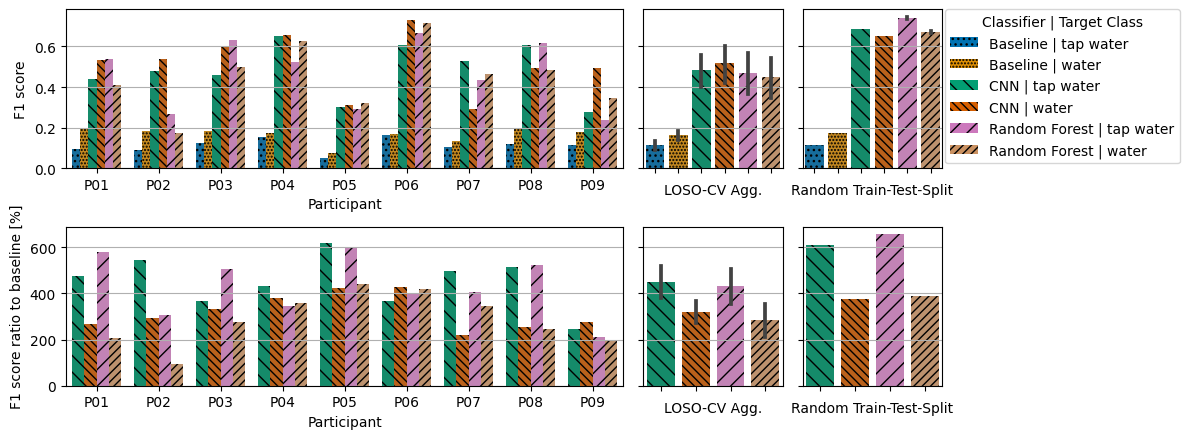

In [78]:
res_df_lo["classifier"] = "Random Forest"
res_df_lo_cnn["classifier"] = "CNN"
data = pd.concat([res_df_lo, res_df_lo_cnn, all_chance_df[all_chance_df.strategy=="uniform"]])



data["group"] = data["classifier"].astype(str) + " | " + data["target"]
data["Participant"] = data["test_part"].apply(lambda x: f"P{str(int(x)+1).zfill(2)}")
classifiers = data["group"].unique()
fig, axes = plt.subplots(2, 3, width_ratios=[4, 1, 1], figsize=(12,4.5), sharey="row")
ax1,ax2,ax3 = axes[0]

sns.barplot(data=data.sort_values(by=["group", "Participant"]), x="Participant", y="f1", hue="group", palette = sns.color_palette("colorblind", len(classifiers)), ax=ax1)


# Define a hatch pattern per classifier (hue)
hatches = ["...", ".....", "\\\\", "\\\\\\\\", "//", "////"]  # Customize as needed

palette = sns.color_palette("colorblind", len(classifiers))

# Apply hatches to the bars
for bars, hatch in zip(ax1.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)

# Create custom legend handles
legend_handles = [
    Patch(facecolor=palette[i], hatch=hatches[i], label=clf)
    for i, clf in enumerate(sorted(classifiers))
]

# Set the new legend
ax1.get_legend().remove()
ax1.set_ylabel("F1 score")

sns.barplot(data=data.sort_values(by=["group", "Participant"]), y="f1", x="group", palette = sns.color_palette("colorblind", len(classifiers)), ax=ax2)

ax2.set_ylabel("")
ax2.set_xlabel("Mean")
ax2.set_xticklabels(["","", "","", "", ""])

ax2.set_xlabel("LOSO-CV Agg.")


sns.barplot(data=res_df.sort_values(by=["group"]), y="f1", x="group", palette = sns.color_palette("colorblind", len(classifiers)), ax=ax3)

ax3.legend(handles=legend_handles, title="Classifier | Target Class", loc='upper left',
    borderaxespad=0, bbox_to_anchor=(1.02,1))
ax3.set_ylabel("")
ax3.set_xlabel("Random Train-Test-Split")
ax3.set_xticklabels(["","", "","", "", ""])
for i in range(6):
    ax2.containers[0][i].set_hatch(hatches[i])
    ax3.containers[0][i].set_hatch(hatches[i])

for ax in [ax1, ax2, ax3]:
    ax.grid(True, axis="y")





tmp_df = data.groupby(["Participant", "target", "classifier"]).mean(numeric_only=True)["f1"]
tmp_df = pd.DataFrame(tmp_df).T

outperf_res_long = []

for i in range(9):
    part = f"P{str(i+1).zfill(2)}"
    tap = (tmp_df[part]["tap water"]["Random Forest"] / tmp_df[part]["tap water"]["Baseline"]).iloc[0] * 100
    water = (tmp_df[part]["water"]["Random Forest"] / tmp_df[part]["water"]["Baseline"]).iloc[0] * 100
    outperf_res_long.append({"Participant" : part, "target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "Random Forest"})
    outperf_res_long.append({"Participant" : part, "target class" : "water", "f1 / baseline f1"  : water, "classifier": "Random Forest"})

    tap = (tmp_df[part]["tap water"]["CNN"] / tmp_df[part]["tap water"]["Baseline"]).iloc[0] * 100
    water = (tmp_df[part]["water"]["CNN"] / tmp_df[part]["water"]["Baseline"]).iloc[0] * 100
    outperf_res_long.append({"Participant" : part, "target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "CNN"})
    outperf_res_long.append({"Participant" : part, "target class" : "water", "f1 / baseline f1"  : water, "classifier": "CNN"})

    
out_long_df = pd.DataFrame(outperf_res_long)

out_long_df["group"] = out_long_df["classifier"].astype(str) + " | " + out_long_df["target class"]

ax1,ax2,ax3 = axes[1]
sns.barplot(data=out_long_df.sort_values(by=["group", "Participant"]), x="Participant", hue="group", y="f1 / baseline f1",
           palette = palette[2:], ax=ax1)

palette = sns.color_palette("colorblind", len(classifiers))

# Apply hatches to the bars
for bars, hatch in zip(ax1.containers, hatches[2:]):
    for bar in bars:
        bar.set_hatch(hatch)

# Create custom legend handles
legend_handles = [
    Patch(facecolor=palette[2:][i], hatch=hatches[2:][i], label=clf)
    for i, clf in enumerate(out_long_df.sort_values(by=["group", "Participant"]).group.unique())
]

# Set the new legend
ax1.get_legend().remove()



sns.barplot(data=out_long_df.sort_values(by=["group", "Participant"]), x="group", y="f1 / baseline f1",
           palette = palette[2:], ax=ax2)
ax2.set_ylabel("")
ax2.set_xlabel("LOSO-CV Agg.")
ax2.set_xticklabels(["","", "",""])



#ax3.legend(handles=legend_handles, title="Classifier | Target Class", loc='upper left',
#    borderaxespad=0, bbox_to_anchor=(1.03,1))

tmp_df = res_df.groupby(["target", "classifier"]).mean(numeric_only=True)["f1"]
tmp_df = pd.DataFrame(tmp_df).T
tmp_df

outperf_res_long = []

tap = (tmp_df["tap water"]["Random Forest"] / tmp_df["tap water"]["Baseline"]).iloc[0] * 100
water = (tmp_df["water"]["Random Forest"] / tmp_df["water"]["Baseline"]).iloc[0] * 100
outperf_res_long.append({"target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "Random Forest"})
outperf_res_long.append({"target class" : "water", "f1 / baseline f1"  : water, "classifier": "Random Forest"})

tap = (tmp_df["tap water"]["CNN"] / tmp_df["tap water"]["Baseline"]).iloc[0] * 100
water = (tmp_df["water"]["CNN"] / tmp_df["water"]["Baseline"]).iloc[0] * 100
outperf_res_long.append({"target class" : "tap water", "f1 / baseline f1" : tap, "classifier": "CNN"})
outperf_res_long.append({"target class" : "water", "f1 / baseline f1"  : water, "classifier": "CNN"})

    
out_long_df = pd.DataFrame(outperf_res_long)
out_long_df["group"] = out_long_df["classifier"].astype(str) + " | " + out_long_df["target class"]
sns.barplot(data=out_long_df.sort_values(by=["group"]), x="group", y="f1 / baseline f1",
           palette = palette[2:], ax=ax3)

for i in range(4):
    ax2.containers[0][i].set_hatch(hatches[i+2])
    ax3.containers[0][i].set_hatch(hatches[i+2])

ax3.set_ylabel("")
ax3.set_xlabel("Random Train-Test-Split")
ax3.set_xticklabels(["","", "",""])

for ax in [ax1, ax2, ax3]:
    ax.grid(True, axis="y")
ax1.set_ylabel("F1 score ratio to baseline [%]")

plt.tight_layout()
plt.savefig("figures/all_perf.pdf")

In [203]:
res_df.groupby(["target", "classifier"]).mean()

C:\Users\Robin\AppData\Local\Temp\ipykernel_13680\3045051345.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_df.groupby(["target", "classifier"]).mean()


f1       acc  precision    recall
target    classifier                                            
tap water Baseline       0.112712  0.505474   0.063683  0.489853
          CNN            0.687154  0.954321   0.636312  0.746827
          Random Forest  0.746121  0.972422   0.927248  0.624347
water     Baseline       0.172930  0.501256   0.104647  0.497645
          CNN            0.649300  0.914800   0.570200  0.753900
          Random Forest  0.672734  0.946397   0.919946  0.530346

In [204]:
out_long_df

,target class,f1 / baseline f1,classifier,group
0,tap water,661.971641,Random Forest,Random Forest | tap water
1,water,389.021085,Random Forest,Random Forest | water
2,tap water,609.654936,CNN,CNN | tap water
3,water,375.469843,CNN,CNN | water


###### res_df_lo_cnn

In [220]:
res_df_lo

,test_part,target,f1,acc,precision,recall,classifier
0,0,water,0.407595,0.897627,0.802993,0.273113,Random Forest
1,1,water,0.171920,0.894654,0.873786,0.095339,Random Forest
2,2,water,0.498095,0.918072,0.843548,0.353378,Random Forest
3,3,water,0.626943,0.930627,0.710720,0.560834,Random Forest
4,4,water,0.323607,0.958858,0.472868,0.245968,Random Forest
5,5,water,0.713600,0.951365,0.838346,0.621170,Random Forest
6,6,water,0.465662,0.950642,0.902597,0.313770,Random Forest
7,7,water,0.482759,0.913211,0.896341,0.330337,Random Forest
8,8,water,0.343775,0.903462,0.646526,0.234136,Random Forest
9,0,tap water,0.537396,0.963469,0.680702,0.443936,Random Forest


In [36]:
all_chance_df[all_chance_df.strategy=="uniform"]

,strategy,f1,acc,precision,recall,target,test_part
3,uniform,0.217316,0.507601,0.136672,0.530110,water,0
3,uniform,0.178826,0.496719,0.110000,0.477754,water,1
3,uniform,0.183086,0.499184,0.112689,0.487838,water,2
3,uniform,0.168080,0.492111,0.101284,0.493627,water,3
3,uniform,0.079522,0.503227,0.042945,0.536290,water,4
3,uniform,0.156960,0.490694,0.093591,0.486072,water,5
3,uniform,0.119956,0.507350,0.068346,0.489842,water,6
3,uniform,0.191438,0.492630,0.118963,0.489888,water,7
3,uniform,0.175350,0.498759,0.106619,0.493435,water,8
3,uniform,0.084507,0.495242,0.046264,0.487414,tap water,0


### Export pytorch models, check best